In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
import numpy as np
from tqdm import tqdm
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

NUM_CLASS = 2
IMAGE_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5

In [2]:
# Define paths to the train and test directories
train_dir = 'data2/train'
val_dir = 'data2/val'
test_dir = 'data2/test'

In [3]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
 )

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
steps_per_epoch_test = len(test_generator)

Found 5000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Model Training and Validation

In [4]:
resnet50_model = Sequential()
# Add ResNet50 base model (without the top classification layers)
#resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))
resnet50_model.add(layers.Dense(NUM_CLASS, activation='softmax'))

# since pre-trained model already trained so we dont need to train it again
resnet50_model.layers[0].trainable = False

resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnet50_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
resnet50_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation//BATCH_SIZE,
    verbose=1,
)

Epoch 1/5


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 137s 137s/step - accuracy: 0.3438 - loss: 0.8963 - val_accuracy: 0.5260 - val_loss: 0.6942
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 102s 102s/step - accuracy: 0.5312 - loss: 0.7096 - val_accuracy: 0.6800 - val_loss: 0.5605
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 105s 105s/step - accuracy: 0.6250 - loss: 0.5885 - val_accuracy: 0.7820 - val_loss: 0.4544
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 90s 90s/step - accuracy: 0.8125 - loss: 0.4689 - val_accuracy: 0.8840 - val_loss: 0.3643
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 105s 105s/step - accuracy: 0.9062 - loss: 0.3481 - val_accuracy: 0.9360 - val_loss: 0.2928


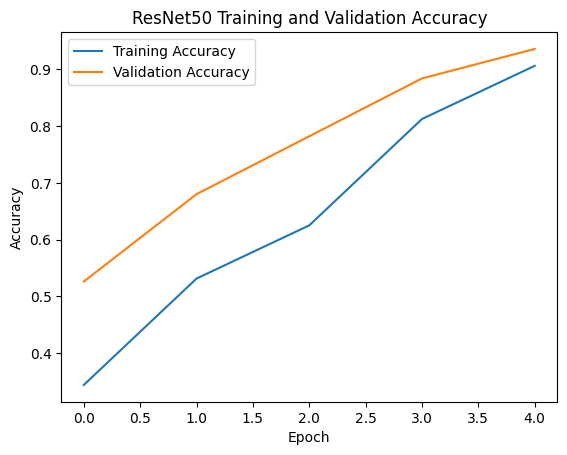

In [6]:
# Plot accuracy
plt.plot(resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.legend()
plt.show()

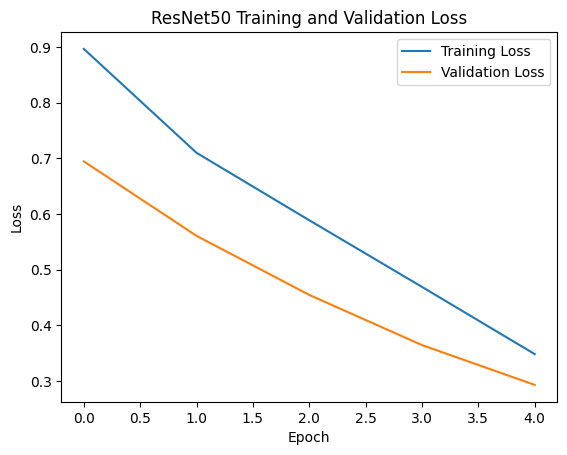

In [7]:
# Plot loss
plt.plot(resnet50_history.history['loss'], label='Training Loss')
plt.plot(resnet50_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step


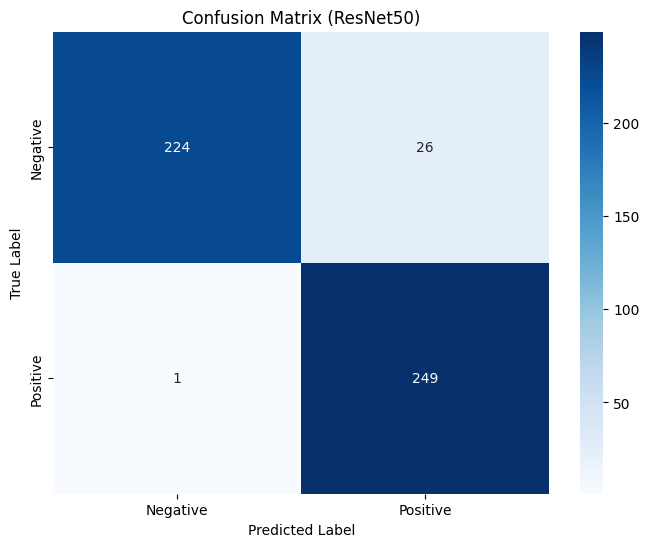

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict classes for test data
y_pred = resnet50_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True classes for test data
true_classes = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (ResNet50)')
plt.show()

In [9]:
import pandas as pd
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, y_pred_classes, target_names=class_labels, output_dict=True)

# Extract precision, recall, and F1-score for each class
metrics_df = pd.DataFrame(report).transpose()

# Select relevant columns
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Display the DataFrame
print(metrics_df)

              precision  recall  f1-score
Negative       0.995556   0.896  0.943158
Positive       0.905455   0.996  0.948571
accuracy       0.946000   0.946  0.946000
macro avg      0.950505   0.946  0.945865
weighted avg   0.950505   0.946  0.945865


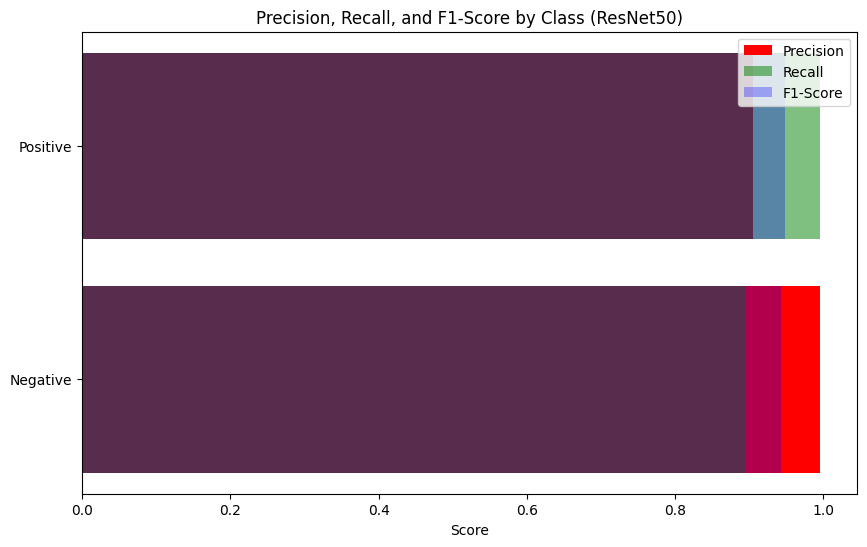

In [10]:
# Generate classification report
report = classification_report(true_classes, y_pred_classes, target_names=class_labels, output_dict=True)

# Extract precision, recall, and F-measure for each class
precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]

# Plot matrix diagram
plt.figure(figsize=(10, 6))
plt.barh(class_labels, precision, color='r', label='Precision')
plt.barh(class_labels, recall, color='g', label='Recall', alpha=0.5)
plt.barh(class_labels, f1_score, color='b', label='F1-Score', alpha=0.3)
plt.xlabel('Score')
plt.title('Precision, Recall, and F1-Score by Class (ResNet50)')
plt.legend()
plt.show()